In [3]:
# Vegas Pre Training pipeline

# Import required libraries
import os
import requests
import zipfile
import tarfile
import torch
import torch.nn.functional as F
import glob
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.windows import from_bounds
from rasterio.features import rasterize
import rasterio.features as rfeat
import geopandas as gpd
from shapely.geometry import box, mapping, Polygon
import pandas as pd
import matplotlib.pyplot as plt
import re
from PIL import Image
import timm
import torchvision.transforms as T
from transformers import AutoImageProcessor, AutoModel
from dinov2.models.vision_transformer import vit_base
import warnings
warnings.filterwarnings("ignore", message="xFormers is not available")

In [ ]:
# Download Sample Spacenet_2 Data 
# This downloads images + building footprints from SpaceNet Las Vegas.

# Note that it is safer to run the below code in paranthesis from the terminal
import os
os.system(
    "aws s3 sync s3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/PS-RGB/ "
    "data/spacenet/AOI_2_Vegas/PS-RGB/ --no-sign-request"
)
os.system(
    "aws s3 sync s3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/geojson_buildings/ "
    "data/spacenet/AOI_2_Vegas/PS-RGB/ --no-sign-request"
)

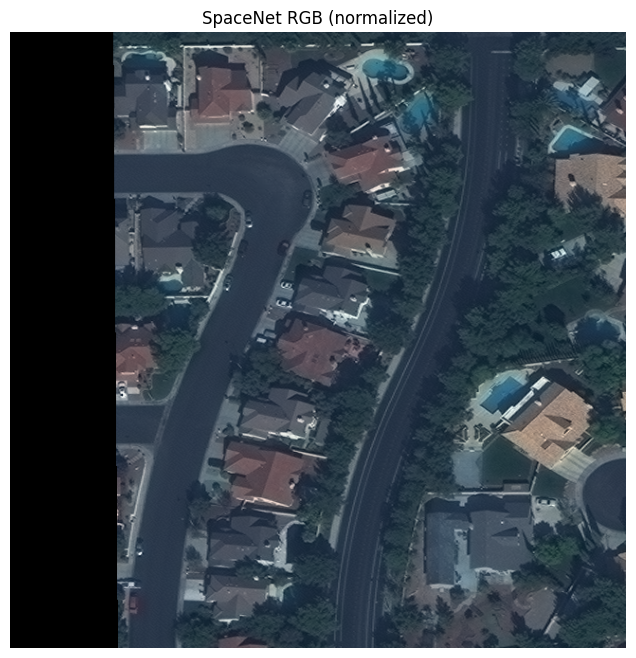

In [19]:
# show an image

img_path = "../data/spacenet/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img8.tif"  # example

with rasterio.open(img_path) as src:
    img = src.read()   # shape: (3, H, W)

# Normalize for visualization
norm = img.astype(float)
for c in range(3):
    norm[c] = (norm[c] - norm[c].min()) / (norm[c].max() - norm[c].min())

# Reorder to HWC
norm = np.transpose(norm, (1, 2, 0))

plt.figure(figsize=(8,8))
plt.imshow(norm)
plt.title("SpaceNet RGB (normalized)")
plt.axis("off")
plt.show()

In [20]:
# show details for an image

ing_path = "../data/spacenet/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1.tif"

with rasterio.open(img_path) as src:
    print("Band count:", src.count)
    print("Shape:", src.read().shape)

Band count: 3
Shape: (3, 650, 650)


In [4]:
# show building footprints head

geojson_path = "../data/spacenet/AOI_2_Vegas/geojson_buildings"

if os.path.exists(geojson_path):
    print("\nGeoJSON building samples:")
    print(sorted(os.listdir(geojson_path))[:20])


GeoJSON building samples:
['SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img1.geojson', 'SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img10.geojson', 'SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img1000.geojson', 'SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img1002.geojson', 'SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img1003.geojson', 'SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img1004.geojson', 'SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img1006.geojson', 'SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img1007.geojson', 'SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img1009.geojson', 'SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img101.geojson', 'SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img1010.geojson', 'SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img1015.geojson', 'SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img1016.geojson', 'SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img1017.geojson', 'SN2_buildin

In [7]:
# show image head

root = "../data/spacenet/AOI_2_Vegas/PS-RGB"

for name in sorted(os.listdir(root))[:20]:   
    print(name)

SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1.tif
SN2_buildings_train_AOI_2_Vegas_PS-RGB_img10.tif
SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1002.tif
SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1003.tif
SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1004.tif
SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1006.tif
SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1007.tif
SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1009.tif
SN2_buildings_train_AOI_2_Vegas_PS-RGB_img101.tif
SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1010.tif
SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1015.tif
SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1016.tif
SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1017.tif
SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1018.tif
SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1021.tif
SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1023.tif
SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1025.tif
SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1028.tif
SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1029.tif
SN2_buildings_train_AOI_2_Vegas_PS-RG

In [25]:
# show image metrics

tile_id = "img101"

geojson_path = f"../data/spacenet/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_{tile_id}.geojson"

gdf = gpd.read_file(geojson_path)

print(gdf.head())
print(gdf.columns)

   OBJECTID  FID_VEGAS_  Id  FID_Vegas  Name  AREA  Shape_Leng  Shape_Le_1  \
0         0           0   0          0  None   0.0         0.0         0.0   
1         0           0   0          0  None   0.0         0.0         0.0   
2         0           0   0          0  None   0.0         0.0         0.0   
3         0           0   0          0  None   0.0         0.0         0.0   
4         0           0   0          0  None   0.0         0.0         0.0   

   SISL  OBJECTID_1  Shape_Le_2  Shape_Le_3  Shape_Area  partialBuilding  \
0   0.0           0         0.0    0.000577         0.0              1.0   
1   0.0           0         0.0    0.000618         0.0              0.0   
2   0.0           0         0.0    0.000621         0.0              1.0   
3   0.0           0         0.0    0.000602         0.0              1.0   
4   0.0           0         0.0    0.001193         0.0              0.0   

   partialDec                                           geometry  
0    0.

In [10]:
# validate building footprint and compute area in sqm


tile_id = "img101"

geojson_path = f"../data/spacenet/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_{tile_id}.geojson"

gdf = gpd.read_file(geojson_path)

# Reproject from EPSG:4326 → EPSG:32611 (UTM zone for Las Vegas)
gdf_utm = gdf.to_crs(epsg=32611)

# Compute real area in square meters
gdf_utm["area_m2"] = gdf_utm.geometry.area

print(gdf_utm.head())
print(gdf_utm[["area_m2"]].describe())

   OBJECTID  FID_VEGAS_  Id  FID_Vegas  Name  AREA  Shape_Leng  Shape_Le_1  \
0         0           0   0          0  None   0.0         0.0         0.0   
1         0           0   0          0  None   0.0         0.0         0.0   
2         0           0   0          0  None   0.0         0.0         0.0   
3         0           0   0          0  None   0.0         0.0         0.0   
4         0           0   0          0  None   0.0         0.0         0.0   

   SISL  OBJECTID_1  Shape_Le_2  Shape_Le_3  Shape_Area  partialBuilding  \
0   0.0           0         0.0    0.000577         0.0              1.0   
1   0.0           0         0.0    0.000618         0.0              0.0   
2   0.0           0         0.0    0.000621         0.0              1.0   
3   0.0           0         0.0    0.000602         0.0              1.0   
4   0.0           0         0.0    0.001193         0.0              0.0   

   partialDec                                           geometry     area_

Image shape: (3, 650, 650)
Mask shape: (650, 650)


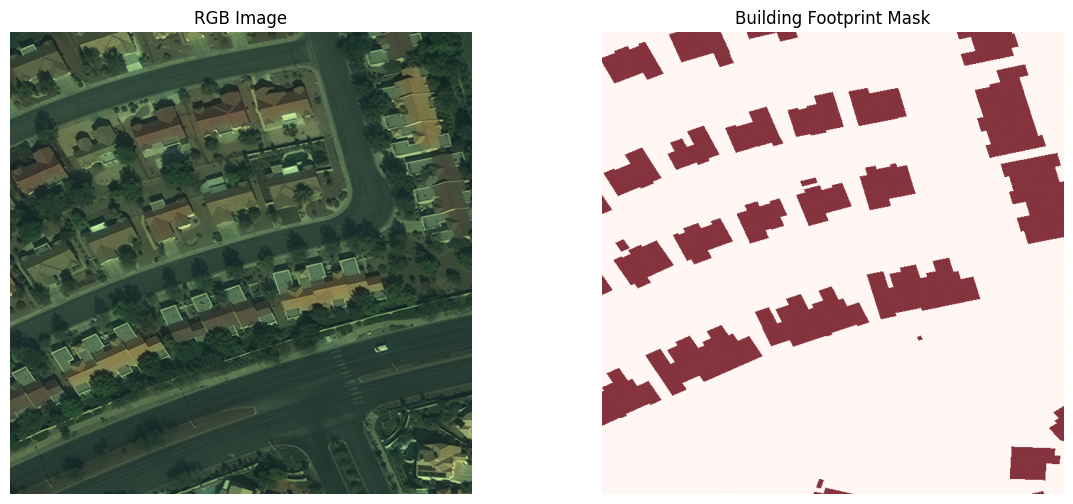

In [26]:
# Test Rasterization Code for  Dataset


# ----- Paths (using ../) -----
tile_id = "img101"

img_path = f"../data/spacenet/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_{tile_id}.tif"
geojson_path = f"../data/spacenet/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_{tile_id}.geojson"

# ----- Load image -----
with rasterio.open(img_path) as src:
    rgb = src.read()  # (3, H, W)
    transform = src.transform
    height, width = rgb.shape[1], rgb.shape[2]

print("Image shape:", rgb.shape)

# ----- Load GeoJSON -----
gdf = gpd.read_file(geojson_path)

# remove Z component (POLYGON Z → POLYGON)
gdf["geometry"] = gdf["geometry"].apply(lambda geom: 
                                        type(geom)([(x,y) for x,y,z in geom.exterior.coords])
                                        if geom.geom_type == "Polygon" else geom)

# ----- Rasterize -----
mask = rasterize(
    [(geom, 1) for geom in gdf.geometry],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype="uint8"
)

print("Mask shape:", mask.shape)

# ----- Normalize image for display -----
rgb_norm = np.transpose(rgb.astype(float), (1,2,0))
rgb_norm = (rgb_norm - rgb_norm.min()) / (rgb_norm.max() - rgb_norm.min())

# ----- Plot -----
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(rgb_norm)
plt.title("RGB Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="Reds", alpha=0.8)
plt.title("Building Footprint Mask")
plt.axis("off")

plt.show()

DINOv2 model loaded successfully.
tokens shape: torch.Size([1, 1370, 768])


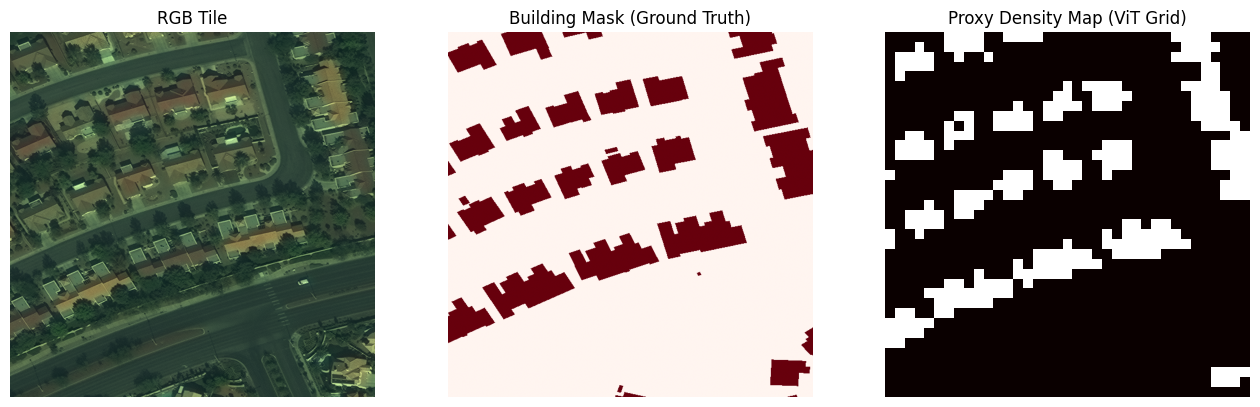

===== EcoVision-Lite Tile Summary =====
Tile ID: img101
Buildings (count): 31
Total footprint area (m²): 6136.680487783345
Mean footprint area (m²): 197.95743508978532
--- Proxy Metrics ---
Proxy index (mean): 0.2001461
Proxy sum: 274.0
Proxy non-zero cells: 274
--- Correlation ---
Correlation between GT and Proxy: 1.0


In [27]:
# Visualize Sample Vegas Data


device = "cuda" if torch.cuda.is_available() else "cpu"


# 1. LOAD DINOv2 MODEL

dinov2_model = timm.create_model(
    "vit_base_patch14_dinov2.lvd142m",
    pretrained=True
)
dinov2_model.eval()
dinov2_model.to(device)

print("DINOv2 model loaded successfully.")


# 2. PIPELINE FOR ONE TILE

tile_id = "img101"

# Paths
img_path = f"../data/spacenet/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_{tile_id}.tif"
geo_path = f"../data/spacenet/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_{tile_id}.geojson"


# 2.1 LOAD RGB IMAGE

with rasterio.open(img_path) as src:
    rgb = src.read()                     # (3, H, W)
    height, width = rgb.shape[1], rgb.shape[2]
    transform = src.transform

# Normalize for display
rgb_norm = rgb.astype(float)
rgb_norm = (rgb_norm - rgb_norm.min()) / (rgb_norm.max() - rgb_norm.min())
rgb_norm = np.transpose(rgb_norm, (1,2,0))


# 2.2 LOAD & CLEAN POLYGONS

gdf = gpd.read_file(geo_path)

# Remove Z component
def strip_z(geom):
    if geom.geom_type == "Polygon":
        return Polygon([(x, y) for x, y, *_ in geom.exterior.coords])
    return geom

gdf["geometry"] = gdf["geometry"].apply(strip_z)


# 2.3 PROJECT POLYGONS TO UTM (ACCURATE AREA)

# WKT UTM zone for Las Vegas area = UTM Zone 11N (EPSG 32611)
gdf_utm = gdf.to_crs(epsg=32611)

# Compute accurate areas
gdf_utm["area_m"] = gdf_utm.geometry.area

building_count = len(gdf_utm)
total_area = gdf_utm["area_m"].sum()
mean_area = gdf_utm["area_m"].mean()


# 2.4 RASTERIZE POLYGONS (GT MASK)

mask = rfeat.rasterize(
    [(geom, 1) for geom in gdf["geometry"]],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype="uint8"
)


# 2.5 PREPARE IMAGE FOR ViT-DINOv2

pil = Image.fromarray((rgb_norm * 255).astype(np.uint8))

preproc = T.Compose([
    T.Resize((518, 518)),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225))
])

x = preproc(pil).unsqueeze(0).to(device)


# 2.6 EXTRACT PATCH TOKENS (tokens.shape = 1×1370×768)

with torch.no_grad():
    tokens = dinov2_model.forward_features(x)
    
print("tokens shape:", tokens.shape)

# GRID SIZE: 1370 patches = 1 CLS + 1369 spatial
num_tokens = tokens.shape[1]
grid = int(np.sqrt(num_tokens - 1))   # 1369 → 37

# Remove CLS token for spatial grid
tokens_spatial = tokens[:, 1:, :]     # shape = (1, 1369, 768)

# Reshape → grid (1, 37, 37, 768)
feat_grid = tokens_spatial.reshape(1, grid, grid, -1).permute(0, 3, 1, 2)
# shape (1, 768, 37, 37)


# 2.7 DOWNSAMPLE MASK TO 37×37

mask_tensor = torch.tensor(mask).float().unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
mask_ds = F.interpolate(mask_tensor, size=(grid, grid), mode="nearest")
mask_ds_np = mask_ds.squeeze().cpu().numpy()


# 2.8 PROXY METRICS

proxy_index = mask_ds_np.mean()
proxy_sum = mask_ds_np.sum()
proxy_nonzero = (mask_ds_np > 0).sum()


# 2.9 SIMPLE CORRELATION (quick check)

corr = np.corrcoef(
    np.array([building_count, total_area]),
    np.array([proxy_index, proxy_sum])
)[0, 1]


# 3. VISUALIZATION

plt.figure(figsize=(16, 5))

plt.subplot(1,3,1)
plt.imshow(rgb_norm)
plt.title("RGB Tile")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask, cmap="Reds")
plt.title("Building Mask (Ground Truth)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(mask_ds_np, cmap="hot")
plt.title("Proxy Density Map (ViT Grid)")
plt.axis("off")

plt.show()


# 4. PRINT SUMMARY

print("===== EcoVision-Lite Tile Summary =====")
print("Tile ID:", tile_id)
print("Buildings (count):", building_count)
print("Total footprint area (m²):", total_area)
print("Mean footprint area (m²):", mean_area)
print("--- Proxy Metrics ---")
print("Proxy index (mean):", proxy_index)
print("Proxy sum:", proxy_sum)
print("Proxy non-zero cells:", proxy_nonzero)
print("--- Correlation ---")
print("Correlation between GT and Proxy:", corr)

In [ ]:
# Reprojection script of night_lights/viirs_global_utm11.tif


# INPUT / OUTPUT PATHS 
VIIRS_WGS84 = "../data/night_lights/VNL_v21_npp_2020_global_vcmslcfg_c202205302300.average_masked.dat.tif"
VIIRS_UTM11 = "../data/night_lights/viirs_global_utm11.tif"

# TARGET CRS — UTM Zone 11N (Las Vegas zone)
TARGET_CRS = "EPSG:32611"

# STEP 1 — OPEN GLOBAL VIIRS
with rasterio.open(VIIRS_WGS84) as src:
    print("Source CRS:", src.crs)
    print("Source bounds:", src.bounds)
    print("Source size:", src.width, src.height)
    
    # STEP 2 — COMPUTE TRANSFORM & OUTPUT SHAPE
    dst_transform, dst_width, dst_height = calculate_default_transform(
        src.crs, TARGET_CRS, src.width, src.height, *src.bounds
    )

    dst_profile = src.profile.copy()
    dst_profile.update({
        "crs": TARGET_CRS,
        "transform": dst_transform,
        "width": dst_width,
        "height": dst_height
    })

    # STEP 3 — WRITE THE REPROJECTED GLOBAL FILE
    with rasterio.open(VIIRS_UTM11, "w", **dst_profile) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=dst_transform,
            dst_crs=TARGET_CRS,
            resampling=Resampling.bilinear
        )

print("DONE — Reprojected VIIRS (Vegas )saved to:", VIIRS_UTM11)

In [ ]:
# extracting all vegas tile metrics and night lights radiance into vegas_all_tile_metrics.csv


# INPUT / OUTPUT PATHS 
TILE_DIR = "../data/spacenet/AOI_2_Vegas/PS-RGB/"
GEOJSON_DIR = "../data/spacenet/AOI_2_Vegas/geojson_buildings/"
OUTPUT_CSV = "../data/output/vegas_all_tile_metrics.csv"

results = []

VIIRS_GLOBAL = "../data/night_lights/viirs_global_utm11.tif"

viirs_ds = rasterio.open(VIIRS_GLOBAL)
viirs_crs = viirs_ds.crs

for img_path in glob.glob(os.path.join(TILE_DIR, "SN2_buildings_train_AOI_2_Vegas_PS-RGB_img*.tif")):

    tile_id = os.path.basename(img_path).split("_img")[1].split(".")[0]

    # Load GEOJSON (footprints)
    gj_path = os.path.join(GEOJSON_DIR, f"SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img{tile_id}.geojson")
    if not os.path.exists(gj_path):
        continue

    gdf = gpd.read_file(gj_path)

    # Reproject shapes to UTM so area is correct
    gdf_utm = gdf.to_crs("EPSG:32611")

    building_count = len(gdf_utm)
    total_area = gdf_utm.area.sum()
    mean_area = gdf_utm.area.mean()

    # Load tile bounds (lat/lon)
    with rasterio.open(img_path) as src:
        b = src.bounds
        # convert to UTM11 bbox
        tile_poly = gpd.GeoSeries([box(b.left, b.bottom, b.right, b.top)], crs=src.crs)
        tile_poly_utm = tile_poly.to_crs("EPSG:32611")
        ub = tile_poly_utm.iloc[0].bounds

    # Crop VIIRS FAST using window
    try:
        win = from_bounds(*ub, transform=viirs_ds.transform)
        arr = viirs_ds.read(1, window=win)
        arr = np.where(arr < 0, 0, arr)
    except:
        arr = np.zeros((1, 1))

    radiance_mean = float(arr.mean())
    radiance_sum = float(arr.sum())
    radiance_nonzero = int((arr > 0).sum())

    # Save metrics
    results.append({
        "tile": tile_id,
        "building_count": building_count,
        "building_total_area_m2": total_area,
        "building_mean_area_m2": mean_area,
        "lights_mean": radiance_mean,
        "lights_sum": radiance_sum,
        "lights_nonzero": radiance_nonzero
    })

df = pd.DataFrame(results)
df.to_csv(OUTPUT_CSV, index=False)
print("Saved:", OUTPUT_CSV)

# Show sample
df.head()

In [ ]:
# Vegas: DINOv2 ViT-B/14 (768-dim) feature extraction


# CONFIG
TILES_DIR = "../data/spacenet/AOI_2_Vegas/PS-RGB"
OUTPUT_CSV = "../data/output/vegas_dinov2_features_768.csv"
MODEL_NAME = "facebook/dinov2-base"

# DEVICE
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# LOAD MODEL
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device).eval()

print("Loaded DINOv2 ViT-B/14 (768-dim)")

# GET ALL TILE PATHS
tile_paths = sorted([os.path.join(TILES_DIR, f)
                     for f in os.listdir(TILES_DIR)
                     if f.endswith(".tif")])

print("Found", len(tile_paths), "tiles.")

# FEATURE EXTRACTION FUNCTION
def load_geotiff_as_pil(path):
    """Load a GeoTIFF tile using rasterio and convert to uint8 RGB PIL."""
    with rasterio.open(path) as src:
        img = src.read()

        # Require at least 3 bands
        if img.shape[0] < 3:
            raise ValueError("Tile has fewer than 3 bands")

        # Take first 3 bands (RGB)
        rgb = img[:3]

        # Normalize to 0–255
        rgb_min = rgb.min()
        rgb_max = rgb.max()

        if rgb_max == rgb_min:
            raise ValueError("Tile is constant image")

        rgb_norm = (255 * (rgb - rgb_min) / (rgb_max - rgb_min)).astype(np.uint8)

        # Convert to HWC for PIL
        rgb_hwc = np.transpose(rgb_norm, (1, 2, 0))

        return Image.fromarray(rgb_hwc)

def extract_feature(path):
    # Extract 768-dim DINOv2 feature vector from GeoTIFF tile.
    try:
        pil_img = load_geotiff_as_pil(path)
    except Exception as e:
        print(f"❌ Error loading TIFF {path}: {e}")
        return None

    try:
        inputs = processor(images=pil_img, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            feat = outputs.pooler_output.squeeze().cpu().numpy()
        return feat
    except Exception as e:
        print(f"❌ Error extracting features {path}: {e}")
        return None

# MAIN LOOP
records = []
for i, path in enumerate(tile_paths):
    tile_id = os.path.basename(path).split(".")[0]

    print(f"[{i+1}/{len(tile_paths)}] Processing {tile_id}...")
    feat = extract_feature(path)

    if feat is not None:
        row = {"tile_id": tile_id}
        for j in range(768):
            row[f"f{j+1}"] = feat[j]
        records.append(row)

# SAVE CSV
df = pd.DataFrame(records)
df.to_csv(OUTPUT_CSV, index=False)

print("\nSaved:", OUTPUT_CSV)
print(df.head())

In [ ]:
# Merge features lights and building metrics


# CONFIG / PATHS
FEATURES_CSV = "../data/output/vegas_dinov2_features_768.csv"
METRICS_CSV  = "../data/output/vegas_all_tile_metrics.csv"
OUT_CSV      = "../data/output/vegas_merged_full.csv"

# Load data
df_feat = pd.read_csv(FEATURES_CSV)
df_met  = pd.read_csv(METRICS_CSV)

print("Features:", df_feat.shape)
print("Metrics: ", df_met.shape)

# CLEAN TILE IDS IN FEATURES CSV - Extract the number after "img" in the filename
def extract_tile_number(path):
    match = re.search(r"img(\d+)", str(path))
    if match:
        return int(match.group(1))
    return None

df_feat["tile_num"] = df_feat["tile_id"].apply(extract_tile_number)

# CLEAN TILE IDs IN METRICS CSV - Ensure metrics tile column is integer
df_met["tile"] = df_met["tile"].astype(int)

# MERGE ON THE CLEANED TILE NUMBER
df_merged = df_met.merge(df_feat, left_on="tile", right_on="tile_num", how="inner")

print("Merged: ", df_merged.shape)

# SAVE

df_merged.to_csv(OUT_CSV, index=False)
print("Saved merged dataset →", OUT_CSV)